In [1]:
# Necessary code for Matplotlib style
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Import dependencies
import numpy as np
import pandas as pd
from datetime import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy.inspection import inspect

In [4]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Show columns in Measurements table
mcolumns = inspect(engine).get_columns('measurement')
mcounter = 0
for column in mcolumns:
    mcounter = mcounter + 1
    print(f'Column {mcounter}: {column["name"]}')

Column 1: id
Column 2: station
Column 3: date
Column 4: prcp
Column 5: tobs


In [10]:
# Show columns in Stations table
scolumns = inspect(engine).get_columns('station')
scounter = 0
for column in scolumns:
    scounter = scounter + 1
    print(f'Column {scounter}: {column["name"]}')

Column 1: id
Column 2: station
Column 3: name
Column 4: latitude
Column 5: longitude
Column 6: elevation


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
dates = session.query(measurements).order_by(measurements.date.desc())
mostrecent = dates.first()
print(f'Most recent date: {mostrecent.date}')

Most recent date: 2017-08-23


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
date0 = dt.strptime(mostrecent.date, '%Y-%m-%d')

# Calculate the date one year from the last date in
yearago = date0.year - 1
date1 = f'{yearago}-{date0.month}-{date0.day}'
date1 = pd.to_datetime(date1, format='%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precdates = session.query(measurements.date, measurements.prcp).\
    filter(measurements.date > date1.strftime('%Y-%m-%d')).\
    order_by(measurements.date).statement

# Save the query results as a Pandas DataFrame
prec_df = pd.read_sql_query(precdates, session.bind)
prec_df = prec_df.dropna()

#Get dates for plotting
pdates = prec_df['date'].to_list()

#Format and set index to date column
prec_df = prec_df.rename(columns={'date': 'Date', 'prcp': 'Precipitation (Inches)'})
prec_df = prec_df.set_index('Date')
prec_df.head()

,Precipitation (Inches)
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


In [13]:
# Get ticks and labels for plotting using the dates
labels = []
for date in pdates:
    getdate = pd.to_datetime(date, format='%Y-%m-%d')
    label = f'{getdate.month}/{getdate.year}'
    if label not in labels:
        labels.append(label)

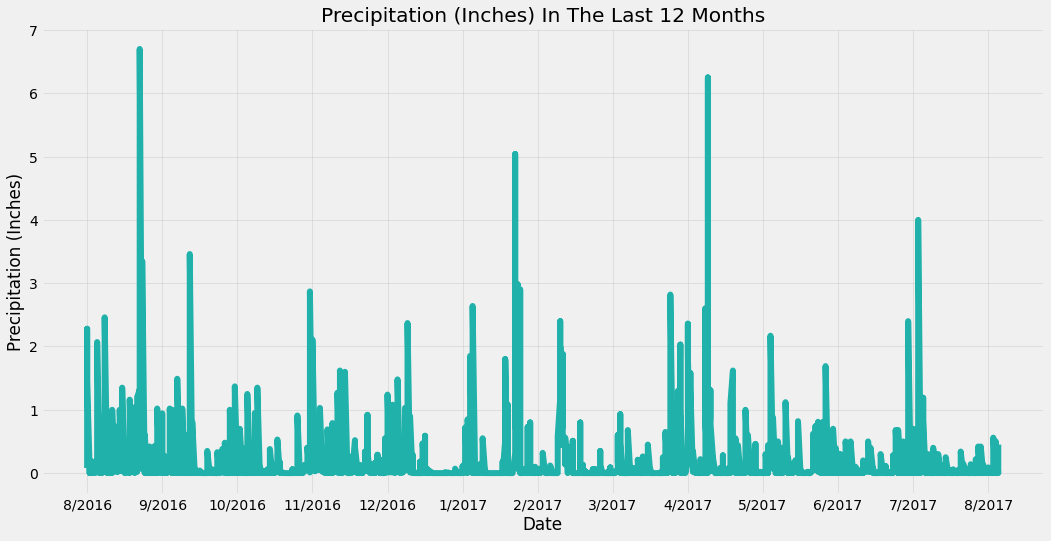

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = pdates                              
y_axis = prec_df['Precipitation (Inches)'].to_list()
plt.figure(figsize=(16,8))
plt.plot(x_axis,y_axis, color='lightseagreen',linewidth=6, markersize=12)
plt.grid(which='major',alpha=0.5)
plt.xticks(np.arange(0, 366, step=30),labels=labels,rotation = 0)
plt.title("Precipitation (Inches) In The Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (Inches)")
plt.savefig('outputs/prec12months.png')
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prec_df.describe()

,Precipitation (Inches)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data, grouping by year
precgroup_df = pd.read_sql_query(precdates, session.bind)
precgroup_df = precgroup_df.groupby(['date']).mean()
precgroup_df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stationss = session.query(stations.name).count()
print(f'Number of stations: {stationss}')

Number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
actstations = session.query(measurements.station,stations.id,func.count(measurements.station)).\
    filter(measurements.station == stations.station).\
    group_by(measurements.station).statement

# List the stations and the counts in descending order.
activestations = pd.read_sql_query(actstations, session.bind)
activestations = activestations.sort_values(by=['count_1'],ascending=False)
activestations = activestations.rename(columns={'station': 'Station', 
                                                'id': 'Station ID',
                                                'count_1': 'Number of Measurements'})
activestations = activestations.reset_index(drop=True)
activestations.head(10)

,Station,Station ID,Number of Measurements
0,USC00519281,7,2772
1,USC00519397,1,2724
2,USC00513117,2,2709
3,USC00519523,6,2669
4,USC00516128,9,2612
5,USC00514830,3,2202
6,USC00511918,8,1979
7,USC00517948,4,1372
8,USC00518838,5,511


In [19]:
# Get the most active station id
most_active_id = activestations.iloc[0,1]
print(f'Most active station ID: {most_active_id}')

Most active station ID: 7


In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mostact_q = session.query(measurements.station,stations.id,func.avg(measurements.tobs),
                          func.max(measurements.tobs),func.min(measurements.tobs)).\
    filter(measurements.station == stations.station).\
    group_by(measurements.station).\
    filter(stations.id == int(most_active_id)).statement
mostactive_stats = pd.read_sql_query(mostact_q, session.bind)
mostactive_stats = mostactive_stats.rename(columns={'station': 'Station', 
                                                    'id': 'Station ID',
                                                    'avg_1': 'Average Temperature',
                                                    'max_1': 'Max Temperature',
                                                    'min_1': 'Min Temperature'})
mostactive_stats = mostactive_stats.round(2)
mostactive_stats.head()

,Station,Station ID,Average Temperature,Max Temperature,Min Temperature
0,USC00519281,7,71.66,85.0,54.0


In [21]:
# Using the most active station id, get the most recent measurement
sdates = session.query(measurements).\
    filter(measurements.station == stations.station).\
    filter(stations.id == int(most_active_id)).\
    order_by(measurements.date.desc())
smostrecent = sdates.first()
print(f'Most recent date for most active station: {smostrecent.date}')

Most recent date for most active station: 2017-08-18


In [22]:
# Query the last 12 months of temperature observation data for this station
# Starting from the most recent data point in the database. 
date00 = dt.strptime(smostrecent.date, '%Y-%m-%d')

# Calculate the date one year from the last date in
yearago0 = date0.year - 1
date10 = f'{yearago0}-{date00.month}-{date00.day}'
date10 = pd.to_datetime(date10, format='%Y-%m-%d')

# Create query and obtain data
precactive_q = session.query(stations.id, measurements.station, measurements.date, measurements.tobs).\
    filter(measurements.station == stations.station).\
    filter(measurements.date > date10.strftime('%Y-%m-%d')).\
    filter(stations.id == int(most_active_id)).\
    order_by(measurements.date).statement
precactive = pd.read_sql_query(precactive_q, session.bind)
precactive = precactive.rename(columns={'station': 'Station', 
                                        'id': 'Station ID',
                                        'date': 'Date',
                                        'tobs': 'Temperature'})
precactive.head()

,Station ID,Station,Date,Temperature
0,7,USC00519281,2016-08-19,79.0
1,7,USC00519281,2016-08-20,81.0
2,7,USC00519281,2016-08-21,79.0
3,7,USC00519281,2016-08-22,78.0
4,7,USC00519281,2016-08-23,77.0


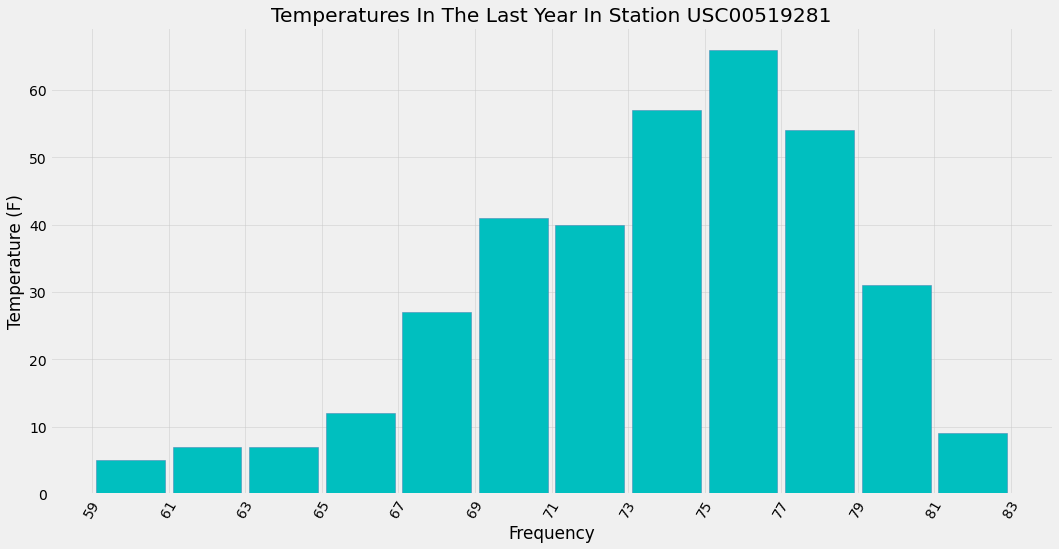

In [23]:
# Plot histogram
sttname = precactive.iloc[0,1]
hist_prec = precactive.drop(['Station ID', 'Station', 'Date'], axis=1)
plt.figure(figsize = (16,8))
n, bins, patches = plt.hist(hist_prec, bins = 12, histtype='bar', align='mid', orientation='vertical', 
         rwidth=.9, color='c', edgecolor='steelblue')
plt.xticks(bins, rotation = 60)
plt.title(f'Temperatures In The Last Year In Station {sttname}')
plt.xlabel('Frequency')
plt.ylabel('Temperature (F)')
plt.grid(alpha=0.5)
plt.savefig('outputs/temps12months.png')
plt.show()

# Close session

In [24]:
# Close Session
session.close()